 Created by Zachary Switzer | Spring 2019 | The George Washington University - MAE 6226

## <P style = "text-align: center;"> Performance of Monoplanes, Biplanes, and Triplanes

### <P style = "text-align: center;"> A Comparison to <i> "Model Airplane Design and Theory of Flight" </i>by Charles Grant 

<img src="Fokker_DR1.JPG" height="300" width="700">

### Some Background

#### What are Monoplanes, Biplanes, and Triplanes?
Most people have seen or at least have a general undertsanding of what biplanes (aircraft with two fixed-wings, in which one is stacked above the other) look like, and nowadays almost everyone has ridden in a monoplane (aircraft with a single fixed-wing). However, planes with more wings have historically been used much less and as a result are generally less widely known. Triplanes are also fixed wing aircraft, in which wings are stacked above one another, but have three wings instead of two. 

#### When were biplanes and triplanes used and why don't we see them as much nowadays?
Biplanes and triplanes were mainly used in WWI due to the fact that the technology for cantilever wings, which is used in monoplanes, had not been fully developed, and the struts between wings in biplanes and triplanes allowed for greater wing stability. The box girder bracing structure of biplanes and triplanes evenly distributed loads throughout the aircraft and allowed for light materials to be used in the wings of planes. With the developments in engine power and wing structural design in the period after WWI, monoplanes gained popularity as they overcame the speed limit inherent in biplanes and triplanes due to the excess drag created by their support struts.

Biplanes and triplanes aren’t utilized as much nowadays because of the speed and lift limitations that are present due to their design. The struts that connect wings and act as structural support also disrupt the flow around the wings and create excess drag that limits speed of the aircraft. Distance between wings also affects the flow around airfoils and can significantly decrease the overall lift of the aircraft if wings are placed too close to one another. However, this decrease in overall lift also allows biplanes and triplanes to fly at larger angles of attack and lower speeds before stalling compared to monoplanes. 

#### The Goal:
This project is motivated by and follows the incredibly insightful (and addictive!) book <i> "Model Airplane Design and Theory of Flight" </i>  by Charles Grant, in which Grant compares the performance of monoplanes, biplanes, and triplanes. In this tutorial we will compare the results (mainly in terms of lift, streamlines, and Cp) gained from a Python-implemented Panel Method and an XFLR5 model to the results described by Charles Grant. By the end of this tutorial you will not only have a much greater understanding of the theory behind monoplanes, biplanes, and triplanes but also (hopefully!) a greater appreciation for the incredible technological advances that have gone into the planes that we fly in today and often take for granted.

<img src="Red_Baron_Albatros.JPG" height="300" width="700">

We begin this tutorial as we do with every great AeroHydro tutorial: by importing our libraries and loading our geometry! 

Because biplanes and triplanes dominated WWI, for this tutorial we will use the Gottingen 174 airfoil from the Albatros D.II, which was used by Manfred von Richthofen (the Red Baron) in November 1916 when he shot down his famous adversary British ace Major Lanoe Hawker VC. This airfoil was acquired from airfoiltools.com and can be found under the name "GOE-174 (Albatros 5020)". 

In [3]:
# importing libraries
import numpy
import os
from scipy import integrate, linalg
import math
from matplotlib import pyplot
%matplotlib inline

In [4]:
# load the geometry of the GOE-174 airfoil
GOE_174 = os.path.join('data', 'GOE-174.csv')
with open(GOE_174, 'r') as infile:
    # creating the monoplane airfoil
    x_m, y_m = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')

The first thing that we'll need to do to venture out of the realm of monoplanes is to add multiple airfoils to the flow and manipulate their position in the space that we're testing in. To do this, let's create a simple function to translate the airfoil geometry from the origin to another location of our choosing. 

This function works off the simple principle that if we want to move a point (or group of points that make up an airfoil in this case) we need to add an offset value to each point's x and y coordinates. 

$$x' =\ x + x_{new}$$
$$y' =\ y + y_{new}$$

In [7]:
# move the geometry of the airfoils to align them
def translate_geo(x_foil, y_foil, x_new, y_new):
    x = x_foil+x_new
    y = y_foil+y_new
    return x,y

Before we get ahead of ourselves though, we'll want to consult <i> "Model Airplane Design and Theory of Flight" </i> and get an idea of what our setup should be.

Grant states that, “The gap between two airfoils affects efficiency and lift; while it is convenient to place them close, the closer they are the less lift is produced as a combination, and efficiency is reduced.” He also mentions that, 

In [8]:
# create the 2nd airfoil for the biplane
# move the second airfoil up by 0.25 in the y direction and 0.1 in the x direction
x_n1, y_n1 = 0.1, 0.25
x_bi, y_bi = translate_geo(x_m, y_m, x_n1, y_n1)

# create the 3rd airfoil for the triplane
# move the 3rd airfoil up by 0.25 in the y direction and -0.1 in the x direction
x_n2, y_n2 = -0.1, 0.5
x_tri, y_tri = translate_geo(x_m, y_m, x_n2, y_n2)

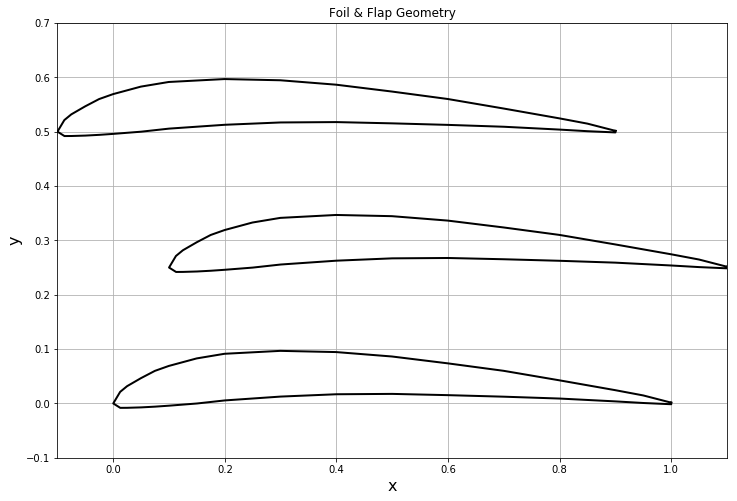

In [9]:
# plot geometry
width = 8
pyplot.figure(figsize=(width*1.5, width))
pyplot.title('Foil & Flap Geometry')
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m, y_m, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_bi, y_bi, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_tri, y_tri, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.7);